# Analisis Prediktif: Prediksi Harga Mobil Bekas di UK

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostRegressor

## 1. Data Loading

### 1.1 Preview dataset

Berikut adalah preview dari keseluruhan file pada dataset

In [5]:
table = pd.DataFrame(columns=['nama', 'baris', 'kolom numerik', 'kolom kategorik', 'file size (kb)'])

for filename in os.listdir('cardata'):
    d = pd.read_csv(os.path.join('cardata',filename))
    size = round(os.path.getsize(os.path.join('cardata',filename)) / 1024, 2)
    table = pd.concat([table, pd.DataFrame({'nama':[filename], 'baris':[d.shape[0]], 'kolom numerik':[len(d.select_dtypes(include=['int64', 'float64']).columns)], 'kolom kategorik':[len(d.select_dtypes(include=['object']).columns)], 'file size (kb)':[size]})], ignore_index=True)
    
display(table)

,nama,baris,kolom numerik,kolom kategorik,file size (kb)
0,audi.csv,10668,6,3,521.55
1,bmw.csv,10781,6,3,578.83
2,cclass.csv,3899,4,3,180.52
3,focus.csv,5454,4,3,228.64
4,ford.csv,17965,6,3,911.42
5,hyundi.csv,4860,6,3,242.43
6,merc.csv,13119,6,3,723.80
7,skoda.csv,6267,6,3,327.28
8,toyota.csv,6738,6,3,339.71
9,unclean cclass.csv,4006,1,10,317.46


Sebagian besar file memiliki jumlah kolom yang sama kecuali pada file cclass, focus, unclean cclass, dan unclean focus.

In [6]:
for filename in os.listdir('cardata'):
    d = pd.read_csv(os.path.join('cardata',filename))
    print('-'*10)
    print(filename)
    print('-'*10)
    for i in d.columns:
        print(i)

----------
audi.csv
----------
model
year
price
transmission
mileage
fuelType
tax
mpg
engineSize
----------
bmw.csv
----------
model
year
price
transmission
mileage
fuelType
tax
mpg
engineSize
----------
cclass.csv
----------
model
year
price
transmission
mileage
fuelType
engineSize
----------
focus.csv
----------
model
year
price
transmission
mileage
fuelType
engineSize
----------
ford.csv
----------
model
year
price
transmission
mileage
fuelType
tax
mpg
engineSize
----------
hyundi.csv
----------
model
year
price
transmission
mileage
fuelType
tax(£)
mpg
engineSize
----------
merc.csv
----------
model
year
price
transmission
mileage
fuelType
tax
mpg
engineSize
----------
skoda.csv
----------
model
year
price
transmission
mileage
fuelType
tax
mpg
engineSize
----------
toyota.csv
----------
model
year
price
transmission
mileage
fuelType
tax
mpg
engineSize
----------
unclean cclass.csv
----------
model
year
price
transmission
mileage
fuel type
engine size
mileage2
fuel type2
engine size2

In [7]:
cclass  = pd.read_csv('cardata/cclass.csv')
display(cclass.head())
ucclass  = pd.read_csv('cardata/unclean cclass.csv')
display(ucclass.head())

,model,year,price,transmission,mileage,fuelType,engineSize
0,C Class,2020,30495,Automatic,1200,Diesel,2.0
1,C Class,2020,29989,Automatic,1000,Petrol,1.5
2,C Class,2020,37899,Automatic,500,Diesel,2.0
3,C Class,2019,30399,Automatic,5000,Diesel,2.0
4,C Class,2019,29899,Automatic,4500,Diesel,2.0


,model,year,price,transmission,mileage,fuel type,engine size,mileage2,fuel type2,engine size2,reference
0,C Class,2020.0,"£30,495",Automatic,NaN,Diesel,2,"1,200",NaN,NaN,/ad/25017331
1,C Class,2020.0,"£29,989",Automatic,NaN,Petrol,1.5,"1,000",NaN,NaN,/ad/25043746
2,C Class,2020.0,"£37,899",Automatic,NaN,Diesel,2,500,NaN,NaN,/ad/25142894
3,C Class,2019.0,"£30,399",Automatic,NaN,Diesel,2,"5,000",NaN,NaN,/ad/24942816
4,C Class,2019.0,"£29,899",Automatic,NaN,Diesel,2,"4,500",NaN,NaN,/ad/24913660


Pada file cclass dan juga focus tidak terdapat kolom tax dan mpg. Masalah ini dapat diatasi dengan mengganti nilai kosong tersebut dengan nilai baru. 

Sementara itu pada file unclean cclass dan unclean focus terdapat beberapa kolom yang tidak ada pada file lain. Namun karena data pada unclean cclass dan juga cclass cenderung sama begitu pula data pada file unclean focus dan focus, maka file unclean cclass dan unclean focus dapat diabaikan.

Data dari file hyundi.csv juga sedikit berbeda dengan data yang lainnya. Pada hyundi fitur pajak diberi nama tax(£) sementara pada file lain fitur pajak diberi nama tax. Untuk itu sebelum seluruh data digabung, data hyundi akan diolah terlebih dahulu dengan mengubah nama fitur tax(£)

### 1.2 Menggabungkan seluruh dataset

In [8]:
df = pd.DataFrame()
for filename in os.listdir('cardata'):
    if filename == 'hyundi.csv':
        continue
    if filename == 'unclean cclass.csv':
        continue
    if filename == 'unclean focus.csv':
        continue
    d = pd.read_csv(os.path.join('cardata',filename))
    df = pd.concat([d, df])
hy = pd.read_csv('cardata/hyundi.csv')
hy.rename(columns = {'tax(£)':'tax'}, inplace=True)
df = pd.concat([df, hy])
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,T-Roc,2019,25000,Automatic,13904,Diesel,145.0,49.6,2.0
1,T-Roc,2019,26883,Automatic,4562,Diesel,145.0,49.6,2.0
2,T-Roc,2019,20000,Manual,7414,Diesel,145.0,50.4,2.0
3,T-Roc,2019,33492,Automatic,4825,Petrol,145.0,32.5,2.0
4,T-Roc,2019,22900,Semi-Auto,6500,Petrol,150.0,39.8,1.5


## 2. Data Understanding

In [9]:
df.shape

(108540, 9)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108540 entries, 0 to 4859
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   model         108540 non-null  object 
 1   year          108540 non-null  int64  
 2   price         108540 non-null  int64  
 3   transmission  108540 non-null  object 
 4   mileage       108540 non-null  int64  
 5   fuelType      108540 non-null  object 
 6   tax           99187 non-null   float64
 7   mpg           99187 non-null   float64
 8   engineSize    108540 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 8.3+ MB


In [11]:
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,108540.000000,108540.000000,108540.000000,99187.000000,99187.000000,108540.000000
mean,2017.098028,16890.124046,23025.928469,120.299838,55.166825,1.661644
std,2.130057,9756.266820,21176.423684,63.150926,16.138522,0.557058
min,1970.000000,450.000000,1.000000,0.000000,0.300000,0.000000
25%,2016.000000,10229.500000,7491.750000,125.000000,47.100000,1.200000
50%,2017.000000,14698.000000,17265.000000,145.000000,54.300000,1.600000
75%,2019.000000,20940.000000,32236.000000,145.000000,62.800000,2.000000
max,2060.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000


Dari tabel diatas, dapat disimpulkan bahwa terdapat nilai 0 pada kolom tax dan engineSize yang tak merupakan hal yang tak wajar. Selain pada beberapa kolom seperti price, mileage, dan mpg, juga memiliki nilai yang terlalu besar dan terlalu kecil yang menandakan keberadaan outlier. Pada kolom tahun juga terdapat nilai tahun lebih dari 2023.

## 3. Exploratory Data Analysis

### 3.1 Menangani data kosong

In [12]:
df.isna().sum()

model              0
year               0
price              0
transmission       0
mileage            0
fuelType           0
tax             9353
mpg             9353
engineSize         0
dtype: int64

Mengganti data yang kosong dengan nilai rata-rata.

In [13]:
df['tax'].fillna(df['tax'].mean(), inplace=True)
df['mpg'].fillna(df['mpg'].mean(), inplace=True)

### 3.2 Menangani fitur numerik bernilai 0
Dari tabel deskripsi dataset, terdapat beberapa kolom yang tak seharusnya memiliki nilai 0, yaitu tax dan juga engineSize. Nilai 0 tersebut akan diganti dengan nilai mean pada kolom tax dan median pada kolom engineSize.

In [14]:
print('Jumlah pajak bernilai 0 ada: ', (df.tax == 0).sum())
print('Jumlah ukuran mesin 0 ada: ', (df.engineSize == 0).sum())

Jumlah pajak bernilai 0 ada:  6294
Jumlah ukuran mesin 0 ada:  286


In [15]:
df['tax'].replace(0, df['tax'].mean(), inplace=True)
df['engineSize'].replace(0, df['engineSize'].median(), inplace=True)

In [16]:
df.shape

(108540, 9)

### 3.3 Menangani outlier
Pada tahap berikut dilakukan pengecekan outlier menggunakan grafik boxplot. Fitur-fitur numerik yang akan dicek antara lain price, mileage, tax, dan mpg.

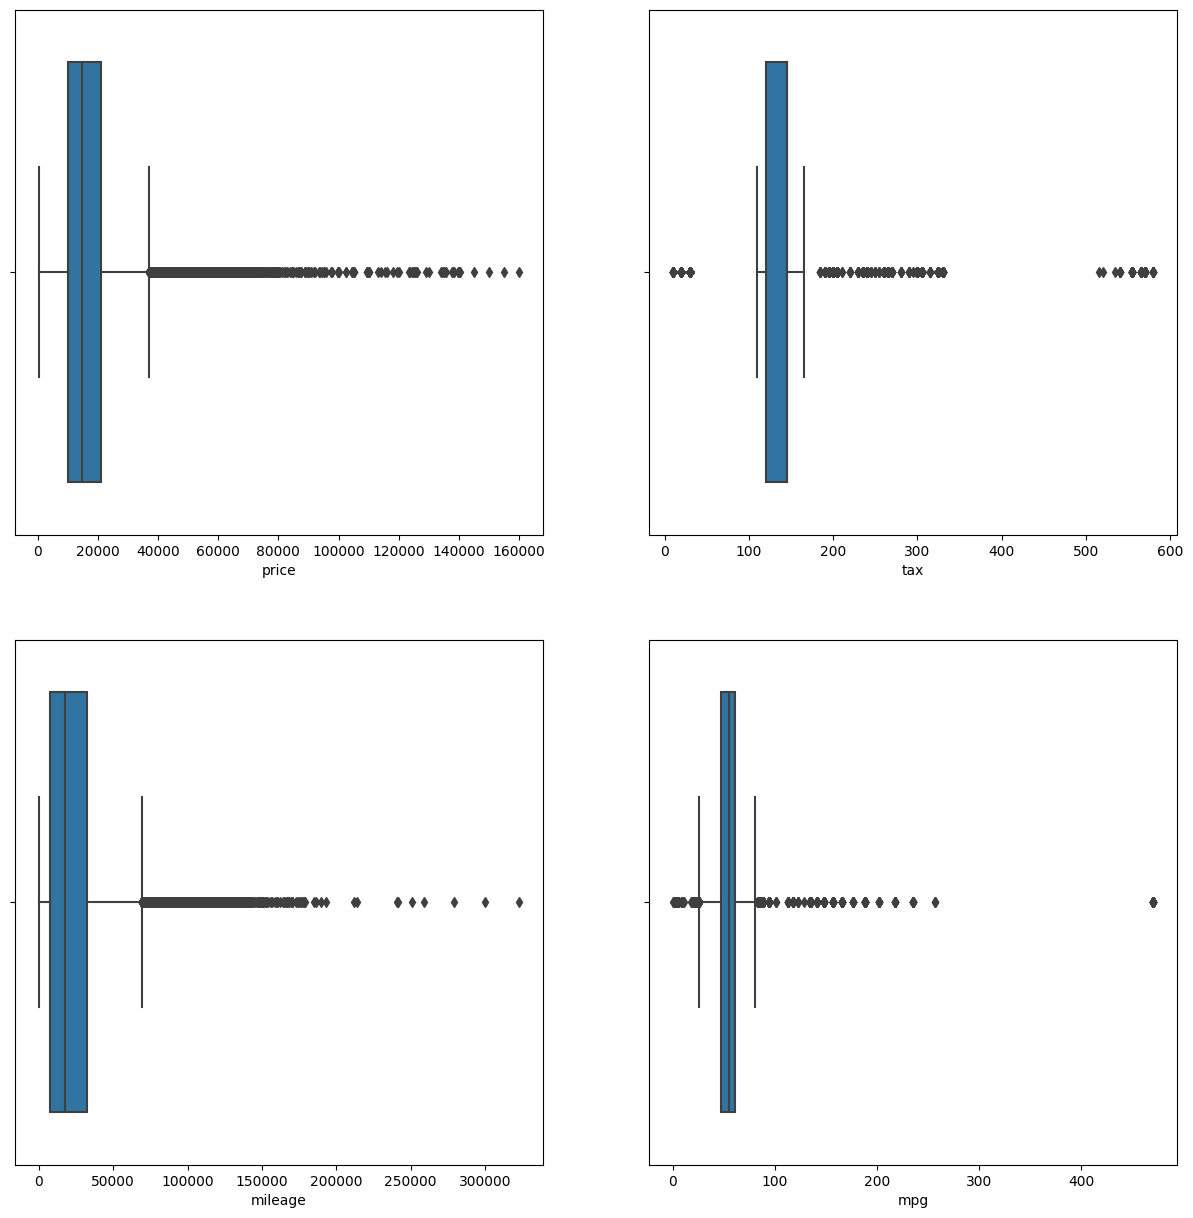

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
sns.boxplot(ax=axs[0, 0], x=df['price'])
sns.boxplot(ax=axs[1, 0], x=df['mileage'])
sns.boxplot(ax=axs[0, 1], x=df['tax'])
sns.boxplot(ax=axs[1, 1], x=df['mpg'])
plt.show()

In [18]:
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
IQR = q3 - q1
atas = q3+(1.5*IQR)
bawah = q1-(1.5*IQR)

dffilter = df[((df['price']<atas['price'])&(df['price']>bawah['price']))
             &((df['mileage']<atas['mileage'])&(df['mileage']>bawah['mileage']))
             &((df['tax']<atas['tax'])&(df['tax']>bawah['tax']))
             &((df['mpg']<atas['mpg'])&(df['mpg']>bawah['mpg']))]

dffilter.shape

(78985, 9)

### 3.4 Menangani nilai maksimal year
Pada kolom year, data yang lebih dari tahun 2023 juga akan disingkirkan.

In [19]:
dffilter = dffilter.loc[(dffilter[['year']]<=2023).all(axis=1)]

### 3.5 Univariative Analysis

Univariative analysis merupakan teknik analisis data yang menganalisa tiap fitur secara individu.

               jumlah sampel  persentase
 Focus                  8765        11.1
 C Class                5995         7.6
 Fiesta                 5835         7.4
 Golf                   3121         4.0
 Corsa                  2366         3.0
...                      ...         ...
 Land Cruiser              1         0.0
 M3                        1         0.0
 Caddy Maxi                1         0.0
 M2                        1         0.0
 Amica                     1         0.0

[157 rows x 2 columns]
157


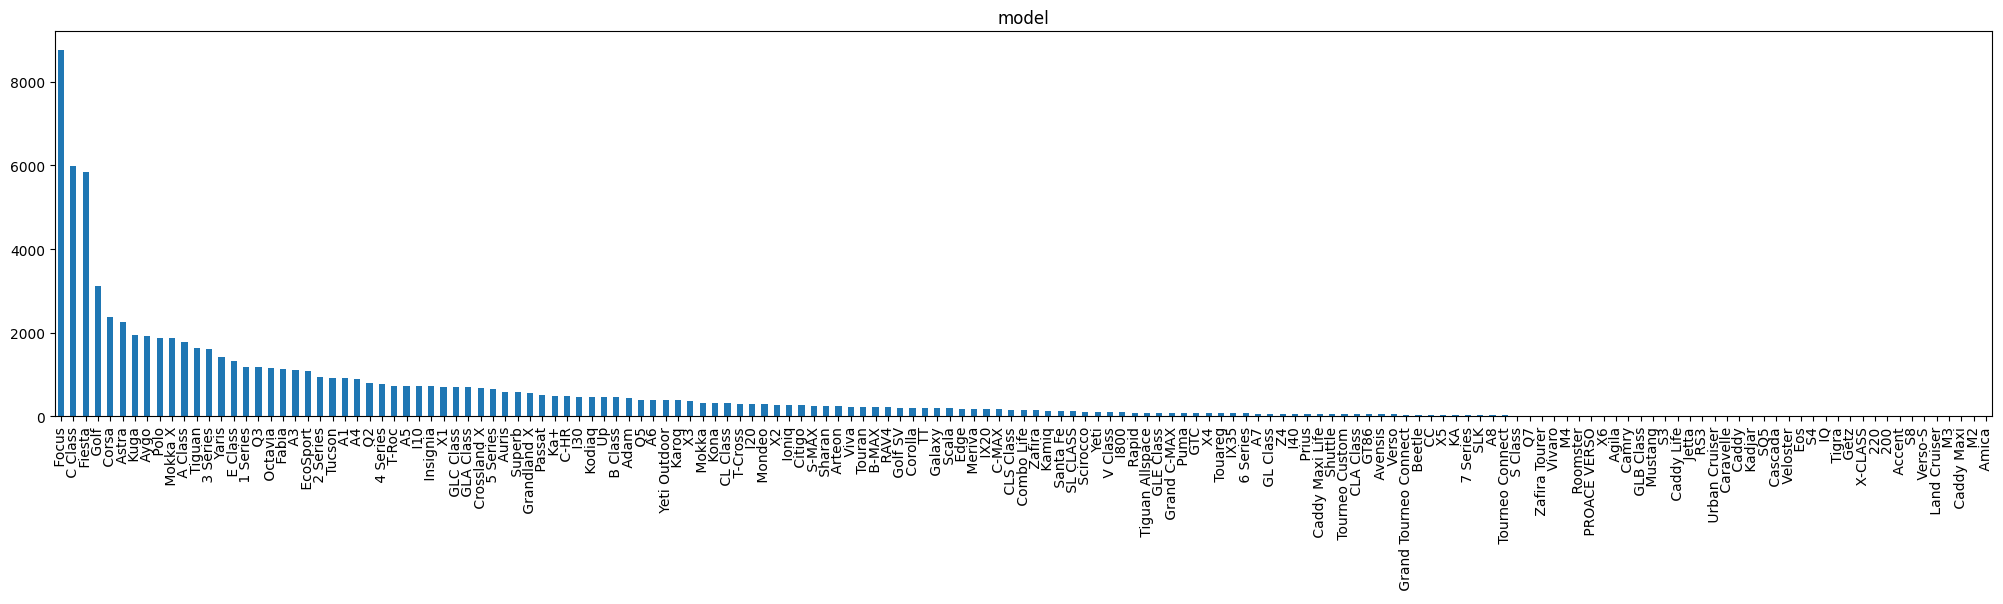

In [20]:
count = dffilter['model'].value_counts()
percent = 100*dffilter['model'].value_counts(normalize=True)
d = pd.DataFrame({'jumlah sampel':count, 'persentase':percent.round(1)})
print(d)
print(dffilter['model'].nunique())

plt.figure(figsize=(25, 5))
count.plot(kind='bar', title='model')
plt.show()

Grafik diatas menunjukkan bahwa terdapat 156 jenis mobil yang terdapat pada dataset, dan mobil merk Fiesta merupakan yang paling banyak dipakai di UK dengan perbedaan banyak yang cukup signifikan dengan mobil kedua yaitu Focus. 

           jumlah sampel  persentase
Manual             44926        56.9
Semi-Auto          18839        23.9
Automatic          15210        19.3
Other                 10         0.0
4


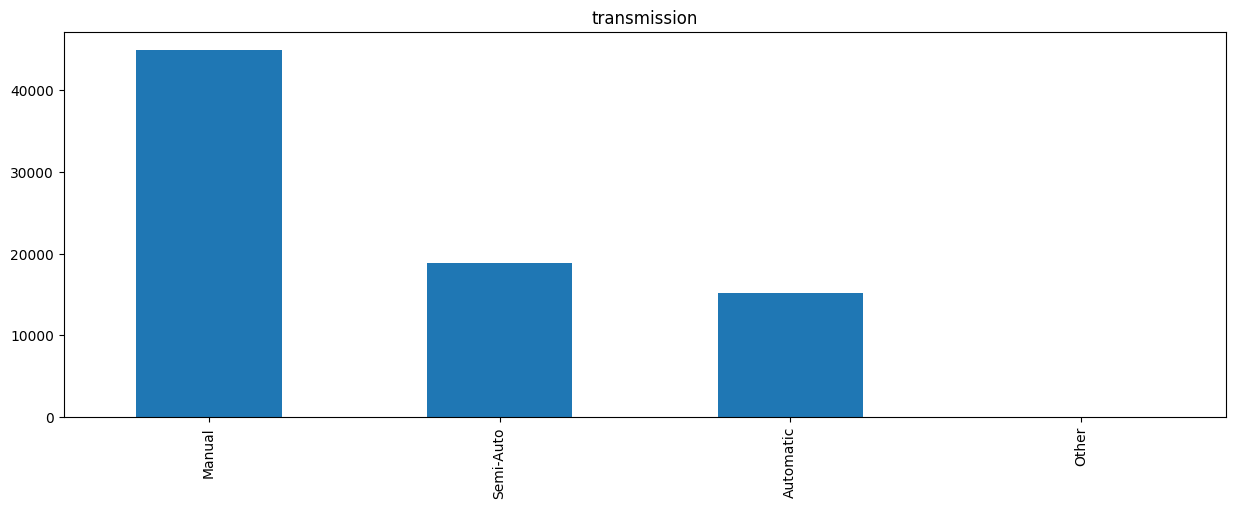

In [21]:
count = dffilter['transmission'].value_counts()
percent = 100*dffilter['transmission'].value_counts(normalize=True)
d = pd.DataFrame({'jumlah sampel':count, 'persentase':percent.round(1)})
print(d)
print(dffilter['transmission'].nunique())

plt.figure(figsize=(15, 5))
count.plot(kind='bar', title='transmission')
plt.show()

Grafik diatas menunjukkan bahwa terdapat 4 jenis transmisi yang terdapat pada dataset, yaitu manual, semi-auto, automatic, dan other. Transmisi manual merupakan yang paling populer. Sementara itu hanya terdapat 6 mobil yang memilki jenis transmisi berjenis other.

          jumlah sampel  persentase
Petrol            46919        59.4
Diesel            29790        37.7
Hybrid             2109         2.7
Other               165         0.2
Electric              2         0.0
5


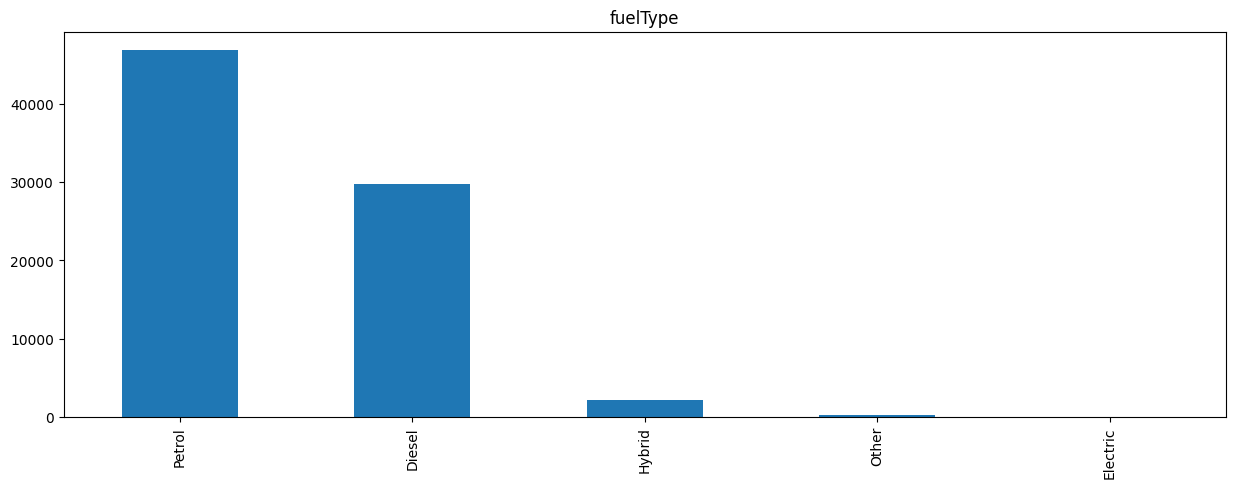

In [22]:
count = dffilter['fuelType'].value_counts()
percent = 100*dffilter['fuelType'].value_counts(normalize=True)
d = pd.DataFrame({'jumlah sampel':count, 'persentase':percent.round(1)})
print(d)
print(dffilter['fuelType'].nunique())

plt.figure(figsize=(15, 5))
count.plot(kind='bar', title='fuelType')
plt.show()

Grafik diatas menunjukkan bahwa terdapat 4 jenis bahan bakar yang terdapat pada dataset, yaitu petrol, diesel, hybrid, dan other. Bahan bakar petrol merupakan yang paling populer digunakan.

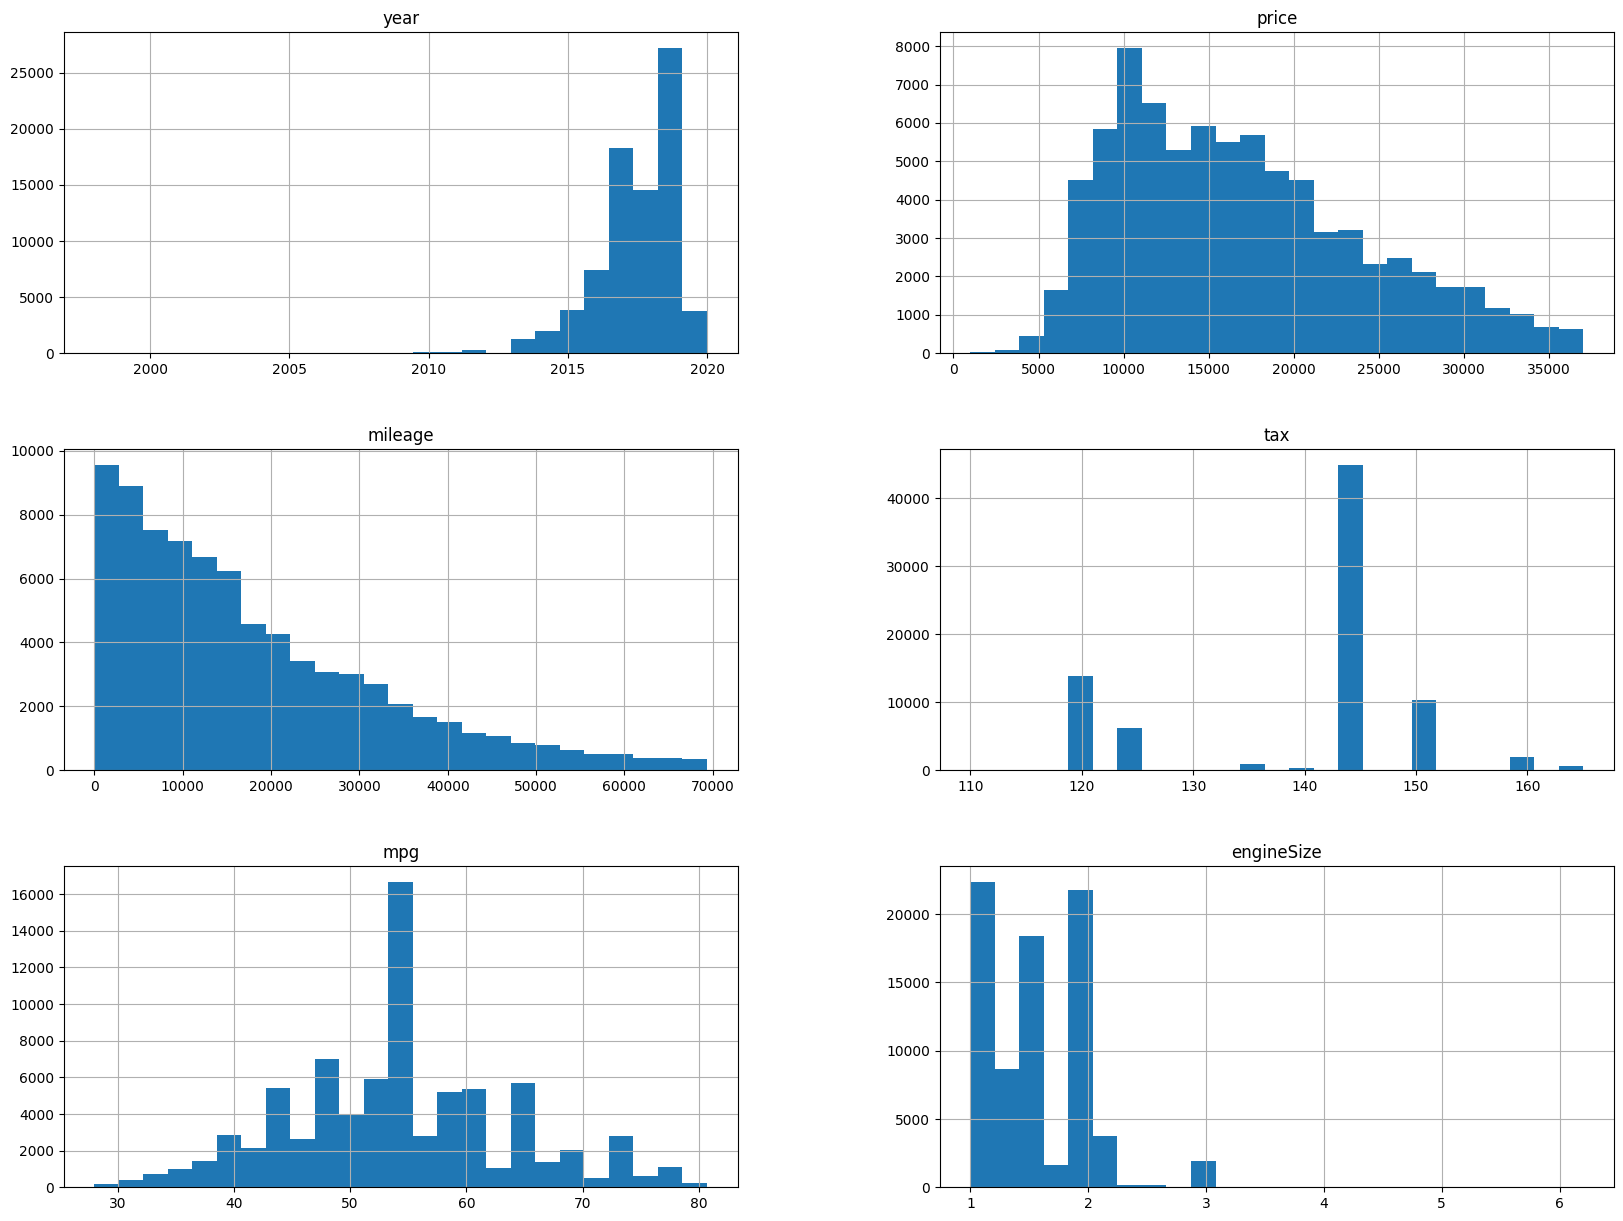

In [23]:
dffilter.hist(bins=25, figsize=(20,15))
plt.show()

### 3.6 Multivariative Analysis

Multivariative analysis merupakan teknik analisa data yang memperhatikan hubungan antar dua atau lebih fitur pada data.

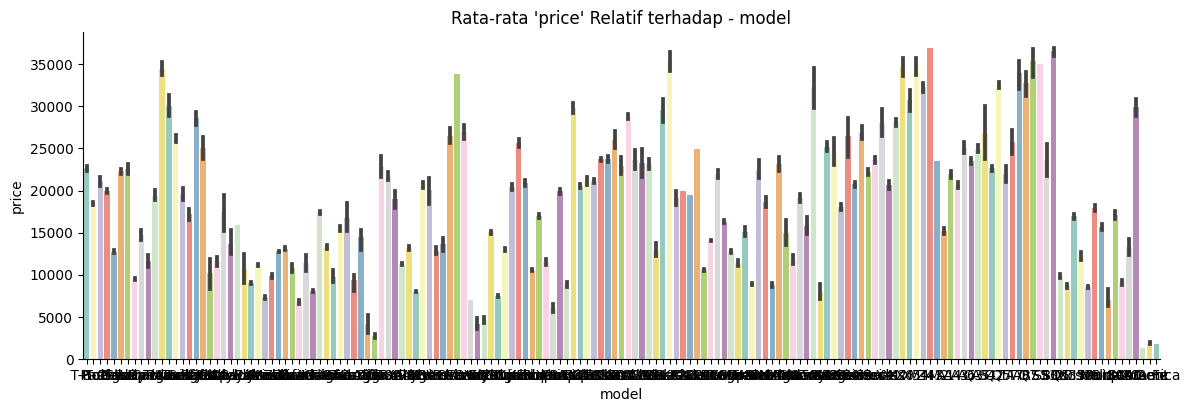

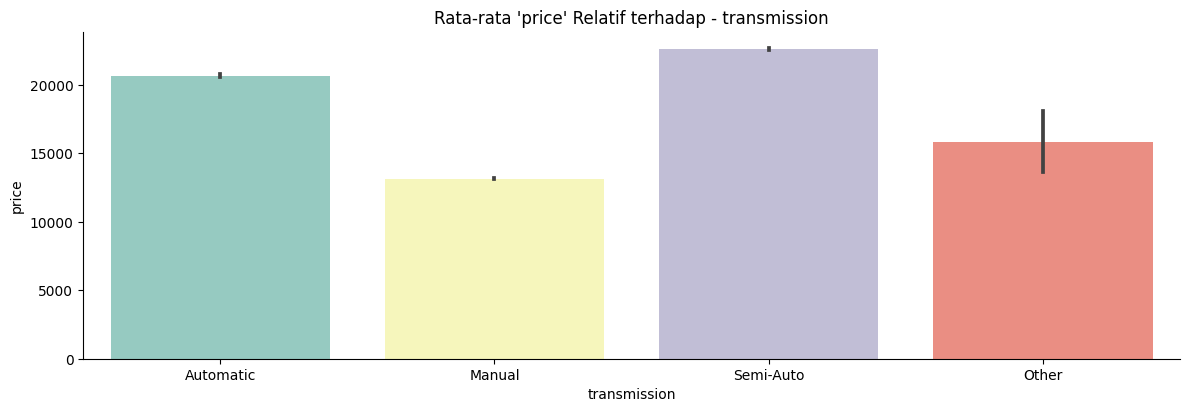

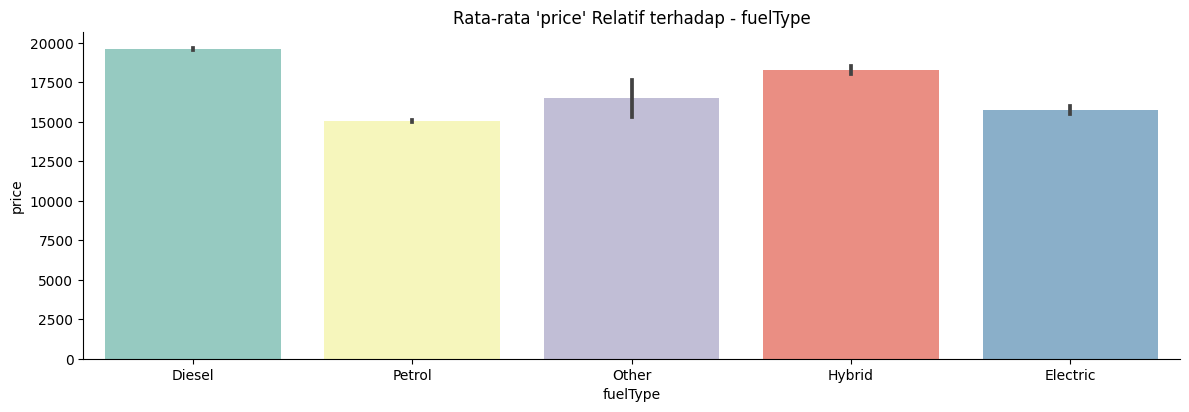

In [24]:
cat_features = dffilter.select_dtypes(include='object').columns.to_list()
 
for col in cat_features:
  sns.catplot(x=col, y="price", kind="bar", dodge=False, height = 4, aspect = 3,  data=dffilter, palette="Set3")
  plt.title("Rata-rata 'price' Relatif terhadap - {}".format(col))

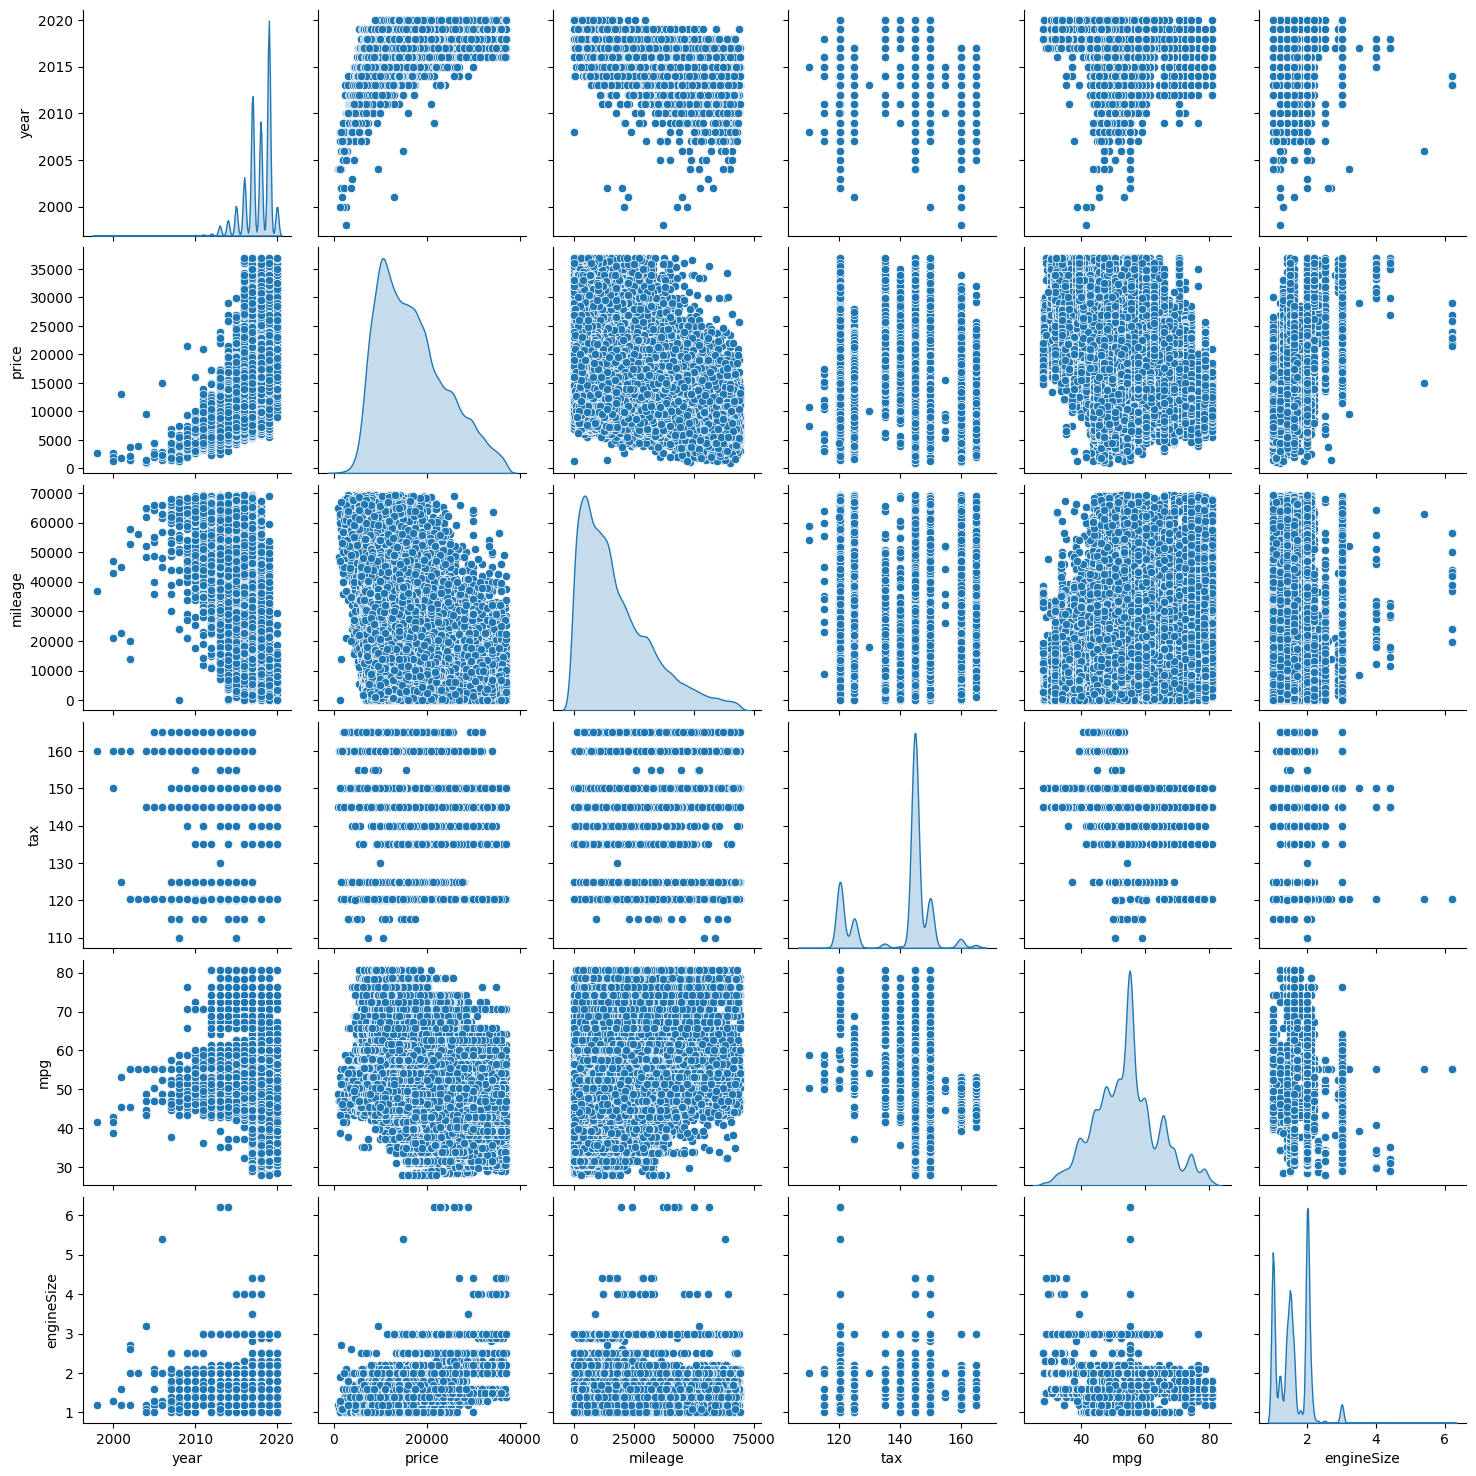

In [25]:
sns.pairplot(dffilter, diag_kind='kde')

Text(0.5, 1.0, 'Correlation Matrix for numerical feature')

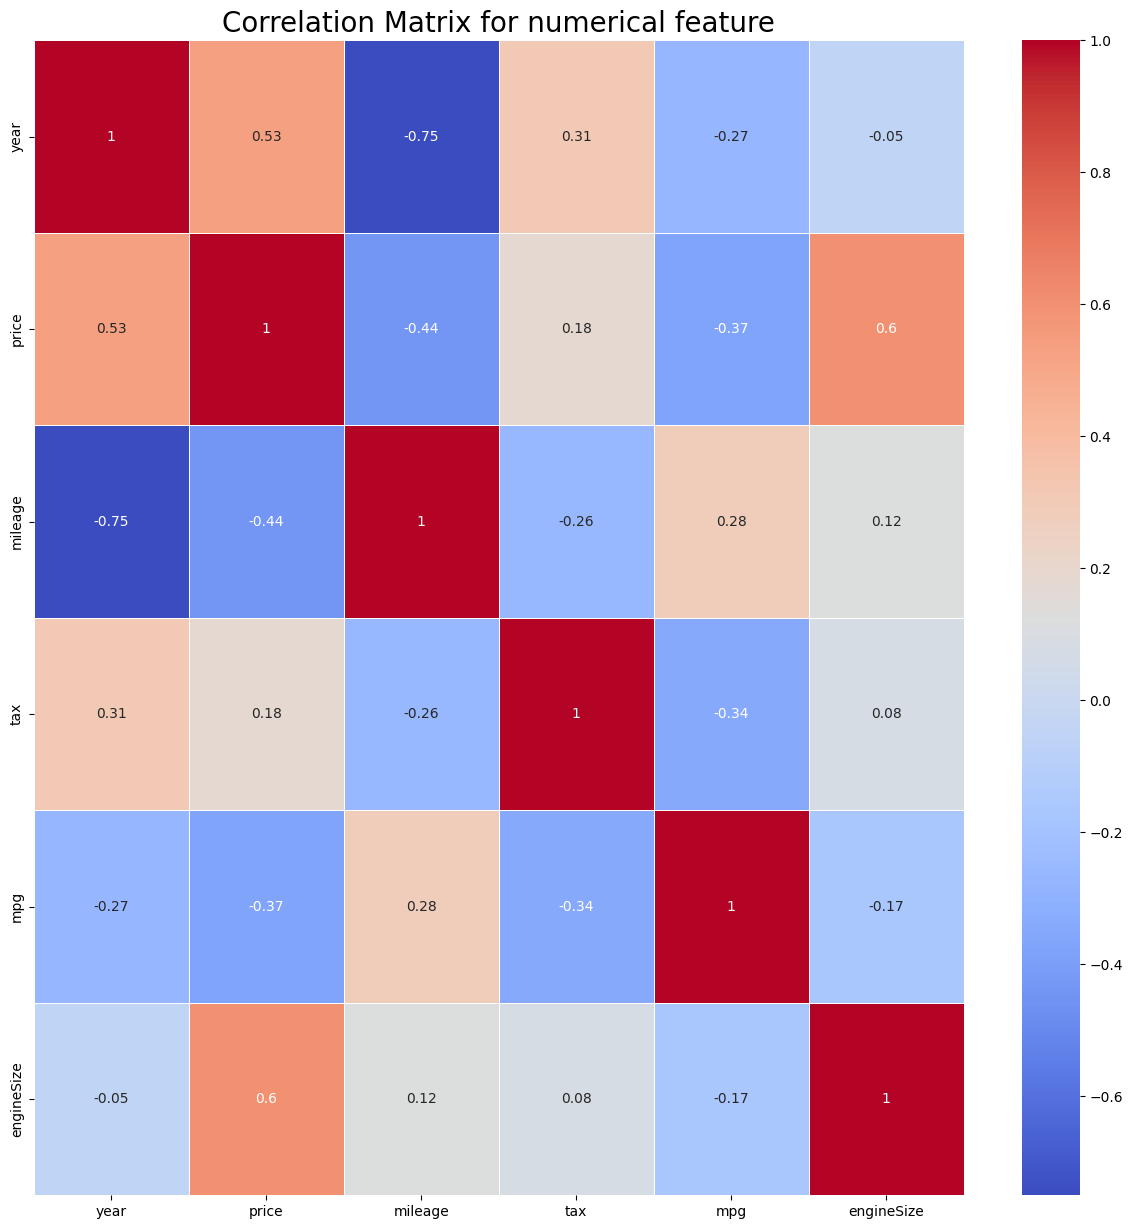

In [26]:
plt.figure(figsize=(15, 15))
correlation_matrix = dffilter.corr().round(2)
sns.heatmap(data = correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for numerical feature', size=20)

Berdasarkan grafik scatterplot dan correlation matrix, jika berpatokan pada fitur price dapat disimpulkan beberapa hal antara lain:

- year: Mobil keluaran tahun terbaru cenderung memiliki harga yang lebih mahal dibanding mobil keluaran tahun yang lebih lama.
- mileage: Mobil dengan mileage yang tinggi cenderung memiliki harga yang lebih murah. Mileage juga dipengauhi oleh umur mobil. 
- engineSize: Mobil dengan ukuran mesin yang besar cenderung memiliki harga yang lebih mahal dibanding mobil dengan ukuran mesin yang lebih kecil.
- mpg: Mobil dengan mpg atau konsumsi bahan bakar mil per galon yang tinggi memiliki harga lebih rendah. Hal ini dapat disebabkan karena banyak mobil dengan harga yang lebih mahal memiliki ukuran mesin yang besar, sehingga mengkonsumsi lebih banyak bahan bakar.
- tax: Jumlah pajak berbanding juga memiliki korelasi kecil dengan harga, dimana mobil dengan pajak yang tinggi cenderung memiliki harga yang tinggi
     

## 4. Data Preparation

### 4.1 Pengolahan fitur year
Untuk mengecilkan interval dari fitur year, fitur year akan diganti dengan fitur age atau umur mobil yang didapat dari hasil 2023 dikurangi tahun pada baris.

In [27]:
dffilter['age'] = 2023 - dffilter['year']
dffilter.drop(columns=['year'], inplace=True)
dffilter.head()

,model,price,transmission,mileage,fuelType,tax,mpg,engineSize,age
0,T-Roc,25000,Automatic,13904,Diesel,145.0,49.6,2.0,4
1,T-Roc,26883,Automatic,4562,Diesel,145.0,49.6,2.0,4
2,T-Roc,20000,Manual,7414,Diesel,145.0,50.4,2.0,4
3,T-Roc,33492,Automatic,4825,Petrol,145.0,32.5,2.0,4
4,T-Roc,22900,Semi-Auto,6500,Petrol,150.0,39.8,1.5,4


### 4.2 Encoding fitur kategorik
Selanjutnya akan dilakukan encoding pada fitur kategori. Dikarenakan pada fitur model terdapat banyak sekali jenis yang berbeda, maka encoding yang dipakai adalah labelencoder.

In [28]:
objlist = dffilter.select_dtypes(include = 'object').columns
print(objlist)

Index(['model', 'transmission', 'fuelType'], dtype='object')


In [29]:
encodeddf = dffilter.copy()
encodeddf.head()

,model,price,transmission,mileage,fuelType,tax,mpg,engineSize,age
0,T-Roc,25000,Automatic,13904,Diesel,145.0,49.6,2.0,4
1,T-Roc,26883,Automatic,4562,Diesel,145.0,49.6,2.0,4
2,T-Roc,20000,Manual,7414,Diesel,145.0,50.4,2.0,4
3,T-Roc,33492,Automatic,4825,Petrol,145.0,32.5,2.0,4
4,T-Roc,22900,Semi-Auto,6500,Petrol,150.0,39.8,1.5,4


In [30]:
le = LabelEncoder()
encodeddf[objlist] = encodeddf[objlist].apply(le.fit_transform)
encodeddf.head()

,model,price,transmission,mileage,fuelType,tax,mpg,engineSize,age
0,124,25000,0,13904,0,145.0,49.6,2.0,4
1,124,26883,0,4562,0,145.0,49.6,2.0,4
2,124,20000,1,7414,0,145.0,50.4,2.0,4
3,124,33492,0,4825,4,145.0,32.5,2.0,4
4,124,22900,3,6500,4,150.0,39.8,1.5,4


### 4.3 Train Test Split

Dataset dibagi ke bagian train dataset dan test dataset. Karena model yang dibuat akan memprediksi fitur price, maka kolom price akan menjadi target y dan sisanya menjadi fitur x.

In [31]:
x = encodeddf.drop(['price'], axis=1)
y = encodeddf['price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.05, random_state = 100)

### 4.4 Data Standardization

Sebelum data diolah lebih lanjut, data akan distandardisasi menggunakan standard scaler sehingga memiliki standar deviasi 1 dan nilai rata-rata 0.

In [32]:
numeric = ['age', 'mileage', 'tax', 'mpg', 'engineSize']
scaler = StandardScaler()
scaler.fit(x_train[numeric])
x_train[numeric] = scaler.transform(x_train.loc[:, numeric])
x_train[numeric].head()

,age,mileage,tax,mpg,engineSize
1529,0.386780,0.513097,-1.759288,0.094869,1.137443
856,1.598404,1.523927,-1.759288,0.094869,0.917944
2010,-0.824844,-0.722951,0.429451,-1.301558,-0.399046
12693,-0.824844,0.288416,0.429451,-2.537892,3.112928
6858,-0.824844,-0.262970,0.429451,1.334593,1.137443


In [33]:
x_test.loc[:, numeric] = scaler.transform(x_test[numeric])

## 5. Model Development

Tahap selanjutnya adalah pengembangan model machine learning yang akan dipakai untuk memprediksi harga mobil bekas. Terdapat 3 algoritma yang akan dipakai antara lain k nearest neighbor, random forest, dan boosting algorithm. Setelah itu akurasi dari setiap model akan diukur. Model dengan akurasi yang tertinggi akan dipakai. 

In [34]:
models = pd.DataFrame(index=['train_mse', 'test_mse'],
                      columns=['KNN', 'RandomForest', 'Boosting'])

### 5.1 Model K Nearest Neighbor

In [35]:
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(x_train, y_train)
models.loc['train_mse', 'knn'] = mean_squared_error(y_pred = knn.predict(x_train), y_true = y_train)

### 5.2 Model Random Forest

In [36]:
RF = RandomForestRegressor(n_estimators=50, max_depth=16, random_state=55, n_jobs=-1)
RF.fit(x_train, y_train)
models.loc['train_mse', 'RandomForest'] = mean_squared_error(y_pred=RF.predict(x_train), y_true=y_train)

### 5.3 Model AdaBoost 

In [37]:
boosting = AdaBoostRegressor(learning_rate=0.05, random_state=55)
boosting.fit(x_train, y_train)
models.loc['train_mse', 'Boosting'] = mean_squared_error(y_pred=boosting.predict(x_train), y_true=y_train)

## Evaluasi

In [ ]:
mse = pd.DataFrame(columns=['train', 'test'], index=['KNN', 'RF', 'Boosting'])
model_dict = {'KNN': knn, 'RF':RF, 'Boosting':boosting}

for name, model in model_dict.items():
    mse.loc[name, 'train'] = mean_squared_error(y_true=y_train, y_pred=model.predict(x_train))/1e3
    mse.loc[name, 'test'] = mean_squared_error(y_true=y_test, y_pred=model.predict(x_test))/1e3
    
mse

,train,test
KNN,2157.043542,2686.927433
RF,1244.647867,2468.617218
Boosting,16145.772919,15677.008501


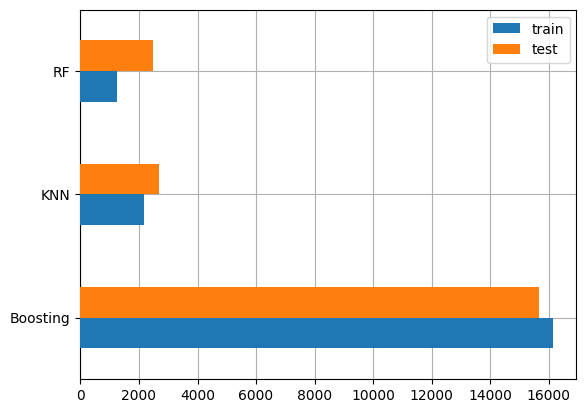

In [ ]:
fig, ax = plt.subplots()
mse[['train', 'test']].sort_values(by='test', ascending=False).plot(kind='barh', ax=ax, zorder=3)
ax.grid(zorder=0)

In [ ]:
prediksi = x_test.iloc[:5].copy()
pred_dict = {'y_true':y_test[:5]}
for name, model in model_dict.items():
    pred_dict['prediksi_'+name] = model.predict(prediksi).round(1)
pd.DataFrame(pred_dict)

,y_true,prediksi_KNN,prediksi_RF,prediksi_Boosting
5654,24000,26716.0,24015.3,24251.1
1131,22052,22618.5,22737.5,20145.6
707,18995,18464.6,17452.2,19628.3
5003,28655,28557.0,28541.4,27764.1
2247,12995,20504.2,16462.2,12457.6
